In [1]:
### This file is the demo data figure for the paper 'Adaptive stretching of representations across brain regions and deep learning model layers'

import pandas as pd
import os
from scipy import stats
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from textwrap import fill
import matplotlib.lines as mlines

In [2]:
def compare(Mtr,Mat):              
    Mcolour_vec=torch.zeros(120)
    Base_vec=np.zeros(120)
    cc=0
    for row in range(16):
      for col in range(row+1,16):
        Mcolour_vec[cc]=Mat[row,col]
        Base_vec[cc]=Mtr[row,col]
        cc+=1
    [corr,pvalue] = stats.spearmanr(Base_vec,Mcolour_vec)
    return corr

/Users/xinyazhang/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


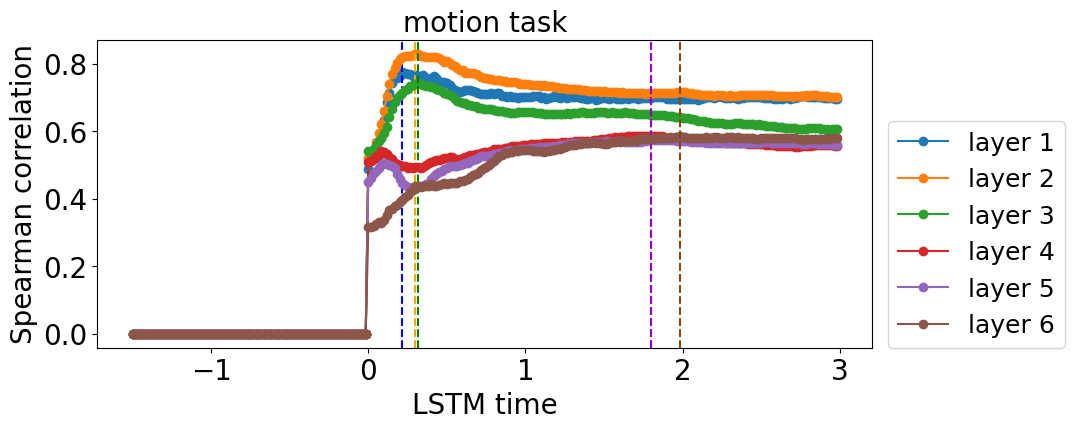

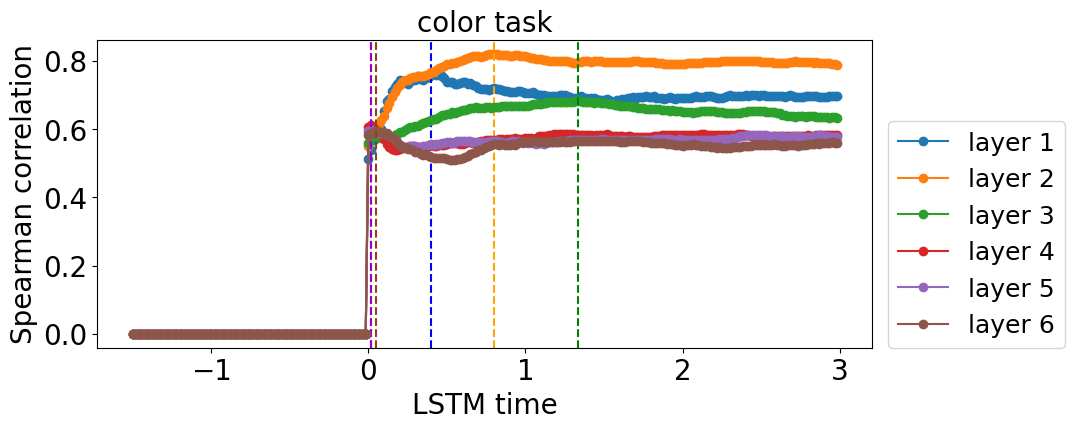

In [3]:
## ****** Spearman correlation on LSTM layers ****** ##
baseline_matrix = torch.load('../data/mini_data_50ms/stimuli_matrix.pt')
bin_size = 50 #ms

colors = ['blue','orange','green','red','darkviolet','saddlebrown']

for task in ['motion', 'color']:
    plt.figure(figsize=(10, 4))
    ll=[]
    for layer in [1,2,3,4,5,6]:
        correlation = []
        time_c=[]
        for time in range(270): #[30+60+180]
            time_c.append(time / 60 - 1.5)  # second
            test_matrix = torch.load(f'../data/layerdata/bs1_{layer}layer_task_{task}_{time}_euc.pt') #Euclidean
            
            ## if cosine
            ## test_matrix = torch.load(f'../data/layerdata/bs1_{layer}layer_task_{task}_{time}_cosine.pt') #Cosine

            correlation.append(compare(test_matrix, baseline_matrix))
            
        correlation = [0 if x is np.nan else x for x in correlation]
        plt.plot(time_c, correlation, 'o-', label=f'layer {layer}')
        
        plt.axvline(x=time_c[correlation.index(np.max(correlation))], color=colors[layer-1], linestyle='--')

    plt.legend( bbox_to_anchor=(1.02, 0), loc=3, borderaxespad=0,fontsize=18)
    plt.xlabel('LSTM time', fontsize=20)
    plt.ylabel('Spearman correlation', fontsize=20)
    plt.title(f'{task} task', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8],fontsize=20)

In [4]:
## ****** Demo for Figure 3 ****** ##
points={1:[90, 90],2:[90, 30],3:[90, -30],4:[90, -90],
    5:[30, 90],6:[30, 30],7:[30, -30],8:[30, -90],
    9:[-30, 90],10:[-30, 30],11:[-30, -30],12:[-30, -90],
    13:[-90, 90],14:[-90, 30],15:[-90, -30],16:[-90, -90]}

def ave_ratio_s(ColourDM,MotionDM,qua):
    dhc=[]
    dvc=[]
    dhm=[]
    dvm=[]
    set=[]
    for comb1 in qua:
        for comb2 in qua:
            if comb1!=comb2:
                idx1 = points[comb1] #[0] color, [1] motion
                idx2 = points[comb2]
                if idx1[0] == idx2[0] : # same color but differ motion
                    dhc.append(float(ColourDM[comb1-1,comb2-1]))
                    dhm.append(float(MotionDM[comb1-1,comb2-1]))
                    # c0+=1
                elif idx1[1] == idx2[1] : # same motion but differ color
                    dvc.append(float(ColourDM[comb1-1,comb2-1]))
                    dvm.append(float(MotionDM[comb1-1,comb2-1]))

    return dhc,dvc,dhm,dvm


def get_distance_from(x,y,task):
    distance_m = []
    distance_c=[]
    for i in range(len(x)):
        point0 = x[i]
        point1 = y[i]

        if task=='color' and i<len(x)/2:
            distance_m.append(point0)
            distance_c.append(point1)
        elif task =='motion' and i>=len(x)/2:
            distance_m.append(point0)
            distance_c.append(point1)
    return np.mean(distance_m), np.mean(distance_c)



def plot_compare(x,y,itv=0.002):
    name = ['mismatch on motion' for i in range(int(len(x) / 2))] + ['mismatch on color' for i in range(int(len(y) / 2))]
    data = {'dc': x, 'dm': y, 'Set': name}
    dhcdhm = pd.DataFrame(data)
    sns.set(style='white',font_scale=1.5) 
    et=max(max(x),max(x)) + itv
    st=min(min(y),min(y)) - itv
    g = sns.jointplot(x="dc", y="dm", hue="Set", data=dhcdhm,height=6,xlim=(st,et),ylim=(st,et))
    g.ax_joint.set_xlabel("Dissimilarity in motion task",fontsize=24)
    g.ax_joint.set_ylabel("Dissimilarity in color task",fontsize=24)
    g.ax_joint.axline((0, 0), slope=1,c='k')
    plt.legend(fontsize=17)
    plt.show()


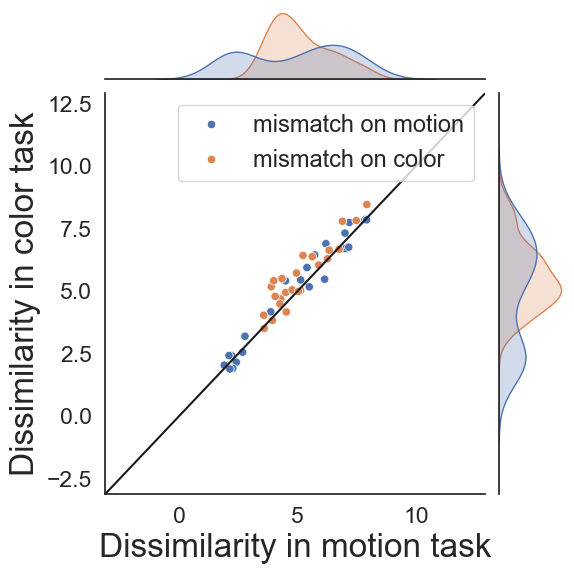

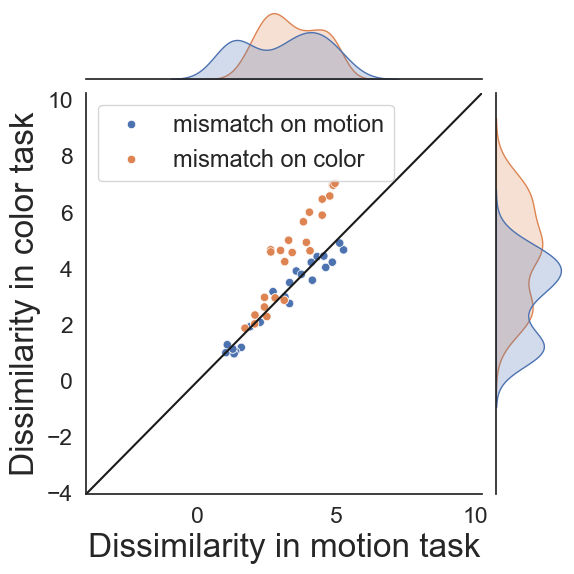

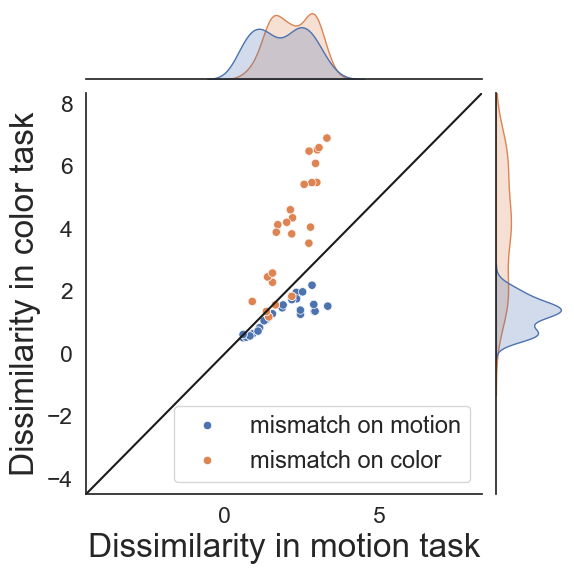

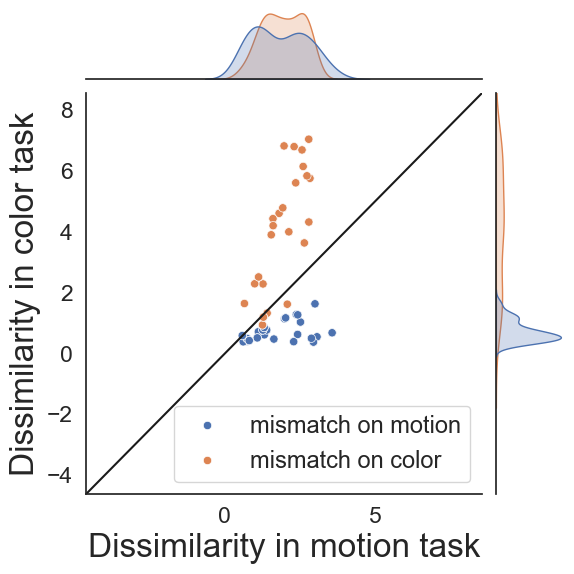

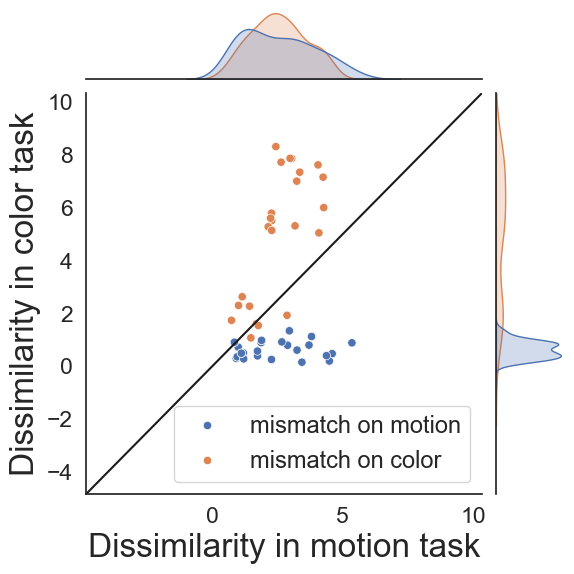

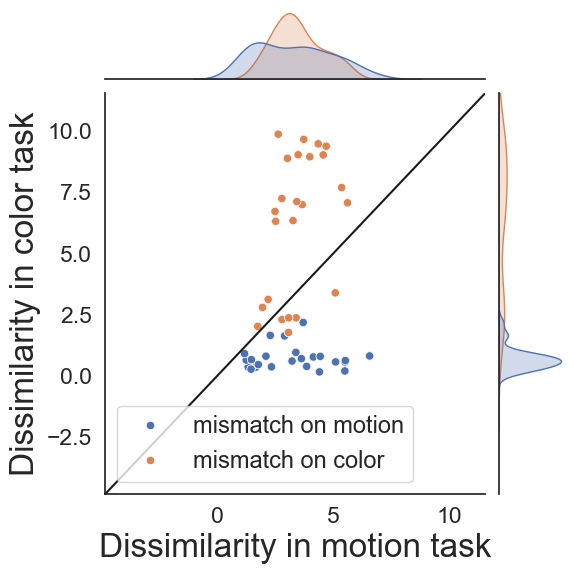

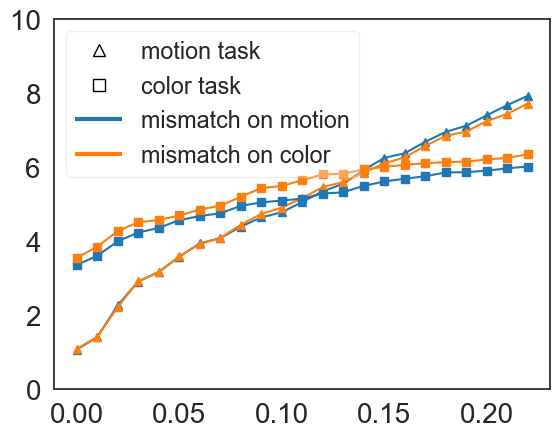

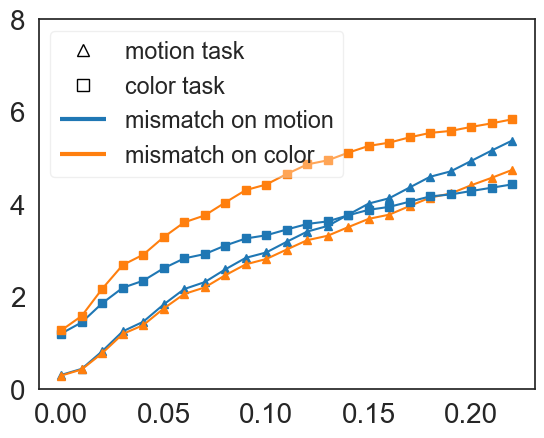

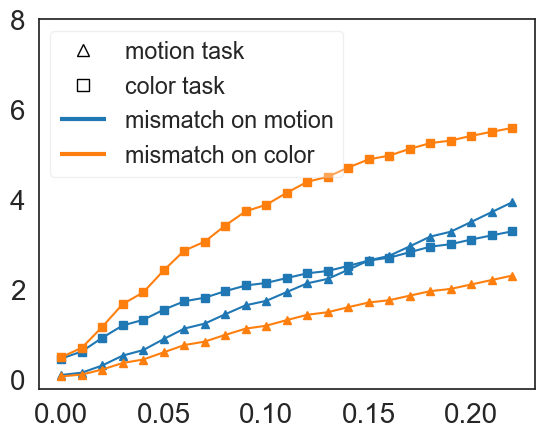

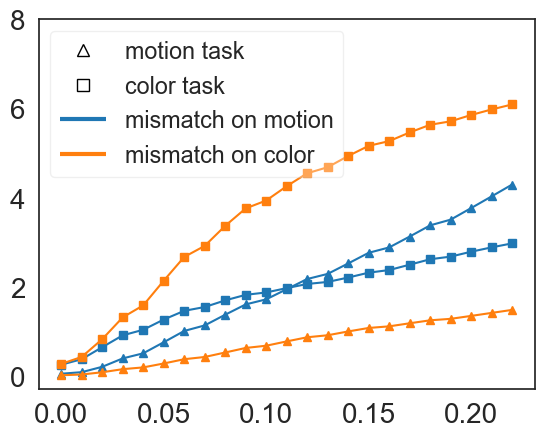

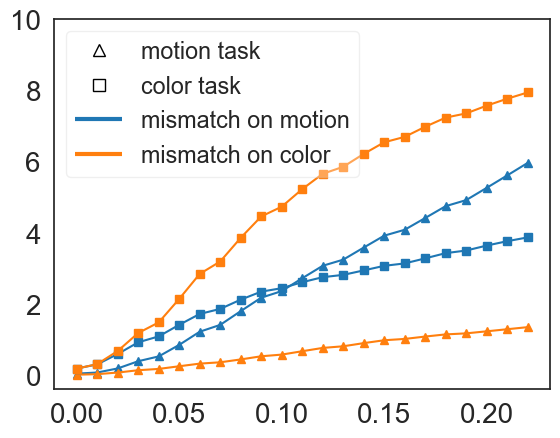

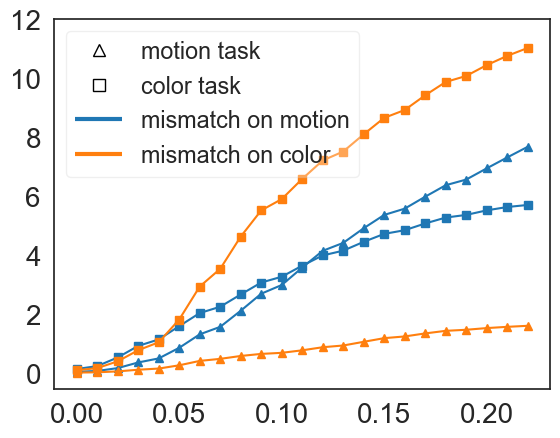

In [5]:
np.set_printoptions(precision=2)

I=[11,12,15,16]
II=[9,10,13,14]
III=[1,2,5,6]
IV=[3,4,7,8]

tim = []
dis = []
q = []

ISI_dhc = []
ISI_dvc = []
ISI_dhm = []
ISI_dvm = []
tas=[]

for layer in [1,2,3,4,5,6]:
    ISI_dhc = []
    ISI_dvc = []
    ISI_dhm = []
    ISI_dvm = []

    ColourDM = torch.load(f'../data/layerdata/bs1_{layer}layer_task_color_long.pt')
    MotionDM = torch.load(f'../data/layerdata/bs1_{layer}layer_task_motion_long.pt')

    dhc, dvc, dhm, dvm = ave_ratio_s(ColourDM, MotionDM,I+II+III+IV)
    ISI_dhc = ISI_dhc + dhc
    ISI_dhm = ISI_dhm + dhm
    ISI_dvc = ISI_dvc + dvc # match on motion
    ISI_dvm = ISI_dvm + dvm # match on motion
    font_size = 2
    y = ISI_dhc + ISI_dvc
    x = ISI_dhm + ISI_dvm
    plot_compare(x, y, itv=5)

upper_time = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22]
col=['tab:blue','tab:orange']
for layer in [1,2,3,4,5,6]:
    fig, ax = plt.subplots()
    for task in ['color', 'motion']:
        tim = []
        dis_m = []
        dis_c=[]
        q_m = []
        q_c=[]

        for time in upper_time:
            MotionDM = torch.load(f'../data/layerdata/bs1_{layer}layer_task_motion_{time}.pt')
            ColourDM = torch.load(f'../data/layerdata/bs1_{layer}layer_task_color_{time}.pt')
            
            dhc, dvc, dhm, dvm = ave_ratio_s(ColourDM, MotionDM, I+II+III+IV)

            ISI_dhc = dhc
            ISI_dhm = dhm
            ISI_dvc = dvc
            ISI_dvm = dvm
            font_size=2
            y=ISI_dhc+ISI_dvc
            x=ISI_dhm+ISI_dvm
            m, c = get_distance_from(x, y, task)  # a number
            dis_m.append(np.mean(m))
            dis_c.append(np.mean(c))

        if task =='motion':
            plt.plot(upper_time,dis_m,'s-',color=col[0])
            plt.plot(upper_time,dis_c,'s-',color=col[1])
        else:
            plt.plot(upper_time,dis_m,'^-',color=col[0])
            plt.plot(upper_time,dis_c,'^-',color=col[1])


        plt.xticks([0.0,0.05,0.1,0.15,0.2],fontsize=20)
        if layer in [1,5]:
            plt.yticks([0,2,4,6,8,10],fontsize=20)
        elif layer in [6]:
            plt.yticks([0,4,8,12],fontsize=20)
        else:
            plt.yticks([0,2,4,6,8],fontsize=20) #euclidean

        marker1 = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=9, markerfacecolor='white', label='color task')
        marker2 = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=9, markerfacecolor='white', label='motion task')
        line_length=1
        marker3 = mlines.Line2D([], [], color='#1f77b4',linestyle='-', linewidth=3,dashes=(line_length, 0),label='mismatch on motion')
        marker4 = mlines.Line2D([], [], color='#ff7f0e',linestyle='-', linewidth=3,dashes=(line_length, 0),label='mismatch on color')
        
        ax.legend(handles=[marker2, marker1,marker3,marker4], loc='upper left', frameon=True, shadow=False,framealpha=0.3,fontsize=16.8)
        
        if layer == 6:
            plt.yticks([0,2,4,6,8,10,12],fontsize=20) #euclidean
        if layer in [1,5]:
            plt.yticks([0,2,4,6,8,10],fontsize=20)

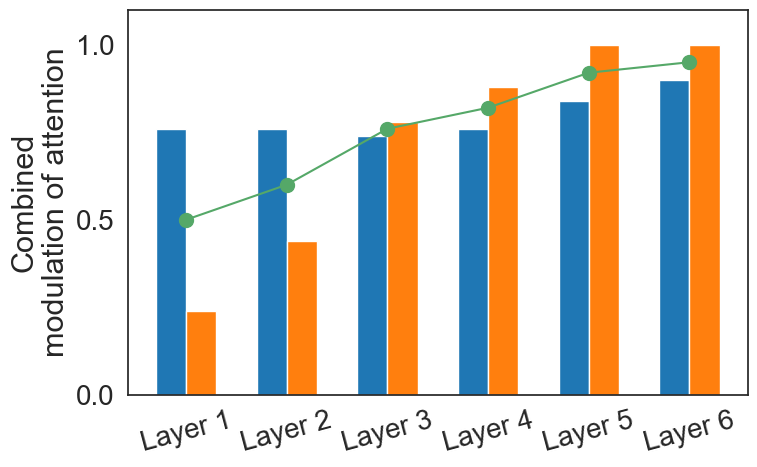

In [6]:
def compare(Mtr, Mat):
    Mcolour_vec = torch.zeros(120)
    Base_vec = np.zeros(120)
    cc = 0
    for row in range(16):
        for col in range(row + 1, 16):
            Mcolour_vec[cc] = Mat[row, col]
            Base_vec[cc] = Mtr[row, col]
            cc += 1

    [corr, pvalue] = stats.spearmanr(Base_vec, Mcolour_vec)
    return corr, pvalue

## ****** Demo for Figure 4 ****** ##

coords = [(1,1),(2,1),(3,1),(4,1),(1,2),(2,2),(3,2),(4,2),(1,3),(2,3),(3,3),(4,3),(1,4),(2,4),(3,4),(4,4)]

plt.figure(figsize=(8,5))
bar_colors = ['#1f77b4','#ff7f0e']

spear_m = []
spear_c = []
timepoints= int(4.5*60 -1)
for task in ['motion','color']:
    att=[]
    for layer in range(1,7):
        cc=[]
        test_matrix = torch.load(f'../data/layerdata/bs1_{layer}layer_task_{task}_{timepoints}_euc.pt')
        for w_m in np.linspace(0,1,50+1):
            matrix_att = torch.zeros((16,16))
            for i in range(len(coords)):
                for j in range(len(coords)):
                    w_c= 1-w_m
                    matrix_att[i,j] = 1 - np.exp(-1*np.sqrt( w_m*(coords[i][0]-coords[j][0])**2 + w_c*(coords[i][1]-coords[j][1])**2 ) )
            cc.append(compare(matrix_att,test_matrix)[0])

        idx = cc.index(max(cc))
        if task =='motion':
            att.append(np.linspace(0,1,50+1)[idx])
            spear_m.append(max(cc))
            at_value = np.linspace(0,1,50+1)[idx]
        else:
            att.append(1-np.linspace(0,1,50+1)[idx])
            spear_c.append(max(cc))
            at_value = 1 - np.linspace(0,1,50+1)[idx]
    x = np.arange(len(att))
    width = 0.3
    plt.bar(x-width/2 + width*['motion', 'color'].index(task), att, width,color=bar_colors[['motion', 'color'].index(task)])

plt.ylim(0,1.2)
plt.xticks(np.arange(0, len(att), 1), ['Layer 1','Layer 2','Layer 3','Layer 4','Layer 5','Layer 6'],fontsize = 20,rotation=15)
plt.yticks([0,0.5,1],fontsize=20)
plt.ylabel('Attention in relevant dimension',fontsize=20) # plt.ylabel('Combined modulation of attention',fontsize=20)


## ****** Demo for modulation attention ****** ##
pear_m = []
spear_c = []
for task in ['motion','color']:
    att=[]
    for layer in range(1,7):
        cc=[]
        test_matrix = torch.load(f'../data/layerdata/bs1_{layer}layer_task_{task}_{timepoints}_euc.pt')
        for w_m in np.linspace(0,1,50+1):
            matrix_att = torch.zeros((16,16))
            for i in range(len(coords)):
                for j in range(len(coords)):
                    w_c= 1-w_m
                    matrix_att[i,j] = 1 - np.exp(-1*np.sqrt( w_m*(coords[i][0]-coords[j][0])**2 + w_c*(coords[i][1]-coords[j][1])**2 ) )
            cc.append(compare(matrix_att,test_matrix)[0])

        idx = cc.index(max(cc))
        if task =='motion':
            att.append(np.linspace(0,1,50+1)[idx])
            spear_m.append(max(cc))
            at_value = np.linspace(0,1,50+1)[idx]
        else:
            att.append(1-np.linspace(0,1,50+1)[idx])
            spear_c.append(max(cc))
            at_value = 1 - np.linspace(0,1,50+1)[idx]
    
    if task=='motion':
        att_temp = att

att = [(np.array(att[i])+np.array(att_temp[i]))/2 for i in range(6)]

x = np.arange(len(att))
plt.plot(x,att,'o-',markersize=10,color='g')#color='#1f78b4')
plt.xticks(np.arange(0, len(att), 1), ['Layer 1','Layer 2','Layer 3','Layer 4','Layer 5','Layer 6'],fontsize = 20,rotation=15)
plt.ylim(0,1.1)
plt.ylabel('Combined\nmodulation of attention',fontsize=22)
plt.show()